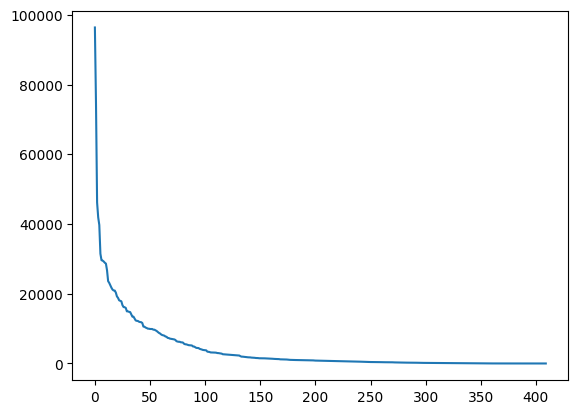

In [2]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt

# Read in data
df = pd.read_csv("English_Cn_Name_Corpus（48W）.txt", header=None, names=["name"], skiprows=2)
names = df["name"].values

# Compute character frequency
chars = [list(name) for name in names]
chars_flatten = list(itertools.chain(*chars))
freq = collections.Counter(chars_flatten)
freq = pd.DataFrame(freq.items(), columns=["char", "freq"])
freq = freq.sort_values(by="freq", ascending=False)


# Frequency distribution
char_rank = np.arange(freq.shape[0])
char_freq = freq["freq"].values
plt.plot(char_rank, char_freq)

In [3]:
# Prepare data
dict_size = 50  # 定义字典的大小，即字符的种类数
charset_size = dict_size + 1  # 字符集的大小，加1是为了考虑终止符（End of Sequence, EOS）
dict = list(freq["char"].values[:dict_size])  # 从名字频率表中取出前 dict_size 个字符作为字典
dict_set = set(dict)  # 将字典转换为集合，方便后续使用

dat = list(filter(lambda name: set(name).issubset(dict_set), names))  # 过滤出只包含字典中字符的名字

# One-hot encoding

## index的目的是后续的one-hot编码：让tensor中的每个字符只在index位置为1，其余位置为0

def char2index(char):
    """将字符映射到字典中的索引"""
    return dict.index(char) # 返回传入字符在字典中的索引

def name2index(name):
    """将名字中的每个字符映射到字典中的索引，返回索引列表"""
    return [char2index(char) for char in name] # 读取名字(name)中的每个字符(char)并映射到字典中的索引，返回索引列表

def char2tensor(char):
    """将单个字符转换为 one-hot 编码的张量"""
    tensor = torch.zeros(1, charset_size) # 相当于一个列向量，长度为charset_size，相当于是对于每个字符对应的one-hot编码向量
    tensor[0, char2index(char)] = 1 # 初始化全员为0，在index位置为1
    return tensor

def name2tensor(name):
    """将名字转换为 one-hot 编码的张量"""
    tensor = torch.zeros(len(name), 1, charset_size) #一个tensor（其实是2d矩阵的感觉），第一个维度是名字的长度（名字中的各个字符），第二个维度是1，第三个维度是每个字符的onehot
    for i, char in enumerate(name): #enmuerate
        tensor[i, 0, char2index(char)] = 1
    return tensor

def names2tensor(names):
    """
    将一批名字转换为 one-hot 编码的张量，并返回张量、每个名字的长度和目标张量
    目标张量是每个名字中每个字符对应的下一个字符的索引
    """
    n = len(names)  # 名字的数量
    lens = [len(name) for name in names]  # 每个名字的长度列表
    max_len = np.max(lens)  # 所有名字中最大的长度
    tensor = torch.zeros(max_len, n, charset_size)  # 用于存储 one-hot 编码的张量
    target = torch.zeros(max_len, n, dtype=int) + charset_size - 1  # 用于存储目标索引的张量，初始值为终止符的索引
    for i in range(n):
        name = names[i]             # 取出第 i 个名字
        for j in range(len(name)):  # 遍历该名字的每个字符
            tensor[j, i, char2index(name[j])] = 1  # 将字符转换为 one-hot 编码并存入张量
            if j < len(name) - 1:
                target[j, i] = char2index(name[j + 1])  # 将目标索引存入张量，表示当前字符的下一个字符的索引
    return tensor, np.array(lens), target

char2index("斯")  # 示例：获取字符“斯”在字典中的索引


1

说明：`enumerate`
enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。这样在正常循环的同时还能获取到循环的索引。
```python
>>> seasons = ['Spring', 'Summer', 'Fall', 'Winter']
>>> list(enumerate(seasons))
[(0, 'Spring'), (1, 'Summer'), (2, 'Fall'), (3, 'Winter')]
```

In [16]:
name2index("斯基")

[1, 17]

In [17]:
char2tensor("斯")

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [4]:
name2tensor("斯基")

tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [5]:
names2tensor(["斯基", "斯诺夫"])

(tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0.,

In [6]:
# Build model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, input_size)
        self.o2o = nn.Linear(hidden_size + input_size, input_size)
        self.dropout = nn.Dropout(0.1)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = torch.relu(self.i2h(input_combined))
        output = torch.relu(self.i2o(input_combined))
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.logsoftmax(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [7]:
n_hidden = 64
rnn = RNN(charset_size, n_hidden)
input = name2tensor("斯基")
hidden = rnn.init_hidden(batch_size=1)
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-3.9068, -3.9949, -3.9079, -3.8755, -3.8405, -3.9780, -3.8976, -3.8831,
         -3.9346, -3.9654, -4.0523, -3.8739, -3.7854, -4.0353, -3.8694, -3.9579,
         -3.8993, -3.8829, -3.9464, -3.9837, -3.9882, -3.9311, -3.8338, -3.9346,
         -3.9226, -3.9702, -3.9111, -3.9863, -3.9346, -3.9018, -3.8391, -4.0053,
         -3.9778, -3.7782, -3.9254, -3.9145, -4.0779, -3.9981, -3.9166, -4.0033,
         -4.0184, -3.9618, -3.9574, -3.8689, -3.9752, -3.9954, -3.9628, -3.9873,
         -3.9713, -3.8215, -3.8891]], grad_fn=<LogSoftmaxBackward0>)

epoch 0, batch 0, loss = 3.9328794479370117
epoch 0, batch 10, loss = 3.537919521331787
epoch 0, batch 20, loss = 3.222890615463257
epoch 0, batch 30, loss = 3.178758382797241
epoch 0, batch 40, loss = 3.1477208137512207
epoch 0, batch 50, loss = 3.123739719390869
epoch 0, batch 60, loss = 3.138552188873291
epoch 0, batch 70, loss = 3.149634838104248
epoch 0, batch 80, loss = 3.1343183517456055
epoch 0, batch 90, loss = 3.1014931201934814
epoch 0, batch 100, loss = 3.0893588066101074
epoch 0, batch 110, loss = 3.0961151123046875
epoch 0, batch 120, loss = 3.074511766433716
epoch 0, batch 130, loss = 3.0096917152404785
epoch 0, batch 140, loss = 3.0294246673583984
epoch 0, batch 150, loss = 3.004396915435791
epoch 0, batch 160, loss = 3.0280535221099854
epoch 0, batch 170, loss = 3.0050034523010254
epoch 0, batch 180, loss = 2.981431007385254
epoch 0, batch 190, loss = 2.9858360290527344
epoch 0, batch 200, loss = 2.9347615242004395
epoch 0, batch 210, loss = 2.936096668243408
epoch 0, 

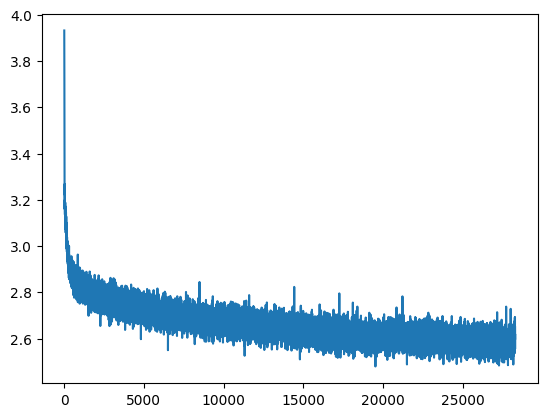

In [8]:
np.random.seed(123)
torch.random.manual_seed(123)
device = torch.device("cuda")
# device = torch.device("cpu")  # If no GPU on the machine

# train_id = np.random.choice(len(dat), 10000)
# train = [dat[i] for i in train_id]
train = dat

n = len(train)
n_hidden = 256
nepoch = 100
bs = 256

rnn = RNN(charset_size, n_hidden)
rnn = rnn.to(device=device)
opt = torch.optim.Adam(rnn.parameters(), lr=0.001)
train_ind = np.arange(n)
lossfn = nn.NLLLoss(reduction="none")
losses = []

t1 = time.time()
for k in range(nepoch):
    np.random.shuffle(train_ind)
    # Update on mini-batches
    for j in range(0, n, bs):
        # Create mini-batch
        ind = train_ind[j:(j + bs)]
        mb = [train[i] for i in ind]
        mb_size = len(mb)
        input, actual_len, target = names2tensor(mb)
        input = input.to(device=device)
        target = target.to(device=device)
        max_len = input.shape[0]
        hidden = rnn.init_hidden(mb_size).to(device=device)
        loss = 0.0
        for s in range(max_len):
            output, hidden = rnn(input[s], hidden)
            loss_s = lossfn(output, target[s])
            valid = torch.tensor((s < actual_len).astype(int)).to(device=device)
            loss = loss + loss_s * valid
        loss = torch.mean(loss / torch.tensor(actual_len).to(device=device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if j // bs % 10 == 0:
            print(f"epoch {k}, batch {j // bs}, loss = {loss.item()}")
t2 = time.time()
print(t2 - t1)
plt.plot(losses)

In [9]:
# torch.save(rnn.state_dict(), "gen_en.pt")
rnn.load_state_dict(torch.load("gen_en.pt", map_location=device))
rnn.eval()

RNN(
  (i2h): Linear(in_features=307, out_features=256, bias=True)
  (i2o): Linear(in_features=307, out_features=51, bias=True)
  (o2o): Linear(in_features=307, out_features=51, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (logsoftmax): LogSoftmax(dim=1)
)

In [10]:
family_names = np.unique([name[0] for name in dat])
def random_family_name():
    return np.random.choice(family_names, 1)[0]

def random_name(max_len=4):
    rnn.eval()
    family_name = random_family_name()
    input = char2tensor(family_name).to(device=device)
    char_ind = [torch.argmax(input).item()]
    hidden = rnn.init_hidden(batch_size=1).to(device=device)
    for i in range(max_len - 1):
        output, hidden = rnn(input, hidden)
        ind = torch.argmax(output).item()
        if ind == charset_size - 1:
            break
        char_ind.append(ind)
        input.zero_()
        input[0, ind] = 1.0
    return char_ind

np.random.seed(123)
torch.random.manual_seed(123)
ind = random_name(10)
print("".join([dict[i] for i in ind]))

雷斯塔


In [11]:
np.random.seed(123)
torch.random.manual_seed(123)
names = []
for i in range(50):
    ind = random_name(10)
    names.append("".join([dict[i] for i in ind]))
np.set_printoptions(linewidth=50)
print(np.array(names))

['雷斯塔' '伊尔马斯' '瓦尔德' '耶尔维' '西尔韦斯特里' '布拉伊科夫斯基'
 '库尔蒂耶' '迪亚科' '拉斯特里' '罗斯托' '维尔斯' '马尔基奥' '埃斯特拉德'
 '维尔斯' '韦尔尼' '维尔斯' '马尔基奥' '格拉斯科' '库尔蒂耶' '尔德'
 '萨尔瓦尼' '维尔斯' '巴尔巴里尼' '内斯托拉' '克拉斯尼奇' '伊尔马斯'
 '德拉斯科' '诺尔贝格' '伊尔马斯' '德拉斯科' '马尔基奥' '勒布罗' '达尔马斯'
 '莱斯科' '瓦尔德' '西尔韦斯特里' '罗斯托' '托尔托拉' '米尔科' '特里斯塔尼'
 '耶尔维' '罗斯托' '奇科' '贝尔托利尼' '克拉斯尼奇' '迪亚科' '利亚尔迪'
 '亚尔马' '塔尔迪' '耶尔维']
